In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import a_matrix_analysis_lib as mat_ansys
import b_spin_representations as su2
import c_evs_visualization_tools as evs_visz_tools
import d_projected_evolution_dynamics as me
import e_Hierarchical_Basis_Evs as HBProjEv

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [2]:
N=6; chain_type = "XY"; k_B = 1; temp = 1e-1; temp_ref = 2e-1

### One body local spin operators
spin_ops_list = su2.one_body_spin_ops(size = N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
Hamiltonian_paras = [-2e-1, -2.5e-1, 0., .5e-1]
H_H = su2.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                           size = N, Hamiltonian_paras = Hamiltonian_paras,
                                           closed_bcs = True, visualization = False)

### Some observables of interest

cl_ops, label_ops = su2.classical_ops(size = N, Hamiltonian = H_H,
                                                op_list = spin_ops_list, centered_x_op = False)

magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
cl_ops["Delta_n^2"] = cl_ops["n_oc_op"]**2; label_ops.append("Delta_n^2")

print("Are all the operators Hermitian?:", mat_ansys.basis_hermitian_check(basis = cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True, True]


In [7]:
# solo algunos observables
subset_of_observables = {}; subset_label_ops = []
subset_of_observables["x_op"] = cl_ops["x_op"]; subset_label_ops.append("x_op")
#subset_of_observables["x_op_sq"] = cl_ops["x_op"]**2; subset_label_ops.append("x_op_sq")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")
subset_of_observables["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; subset_label_ops.append("n_oc_op_sq")
subset_of_observables["p_op"] = cl_ops["p_op"]; subset_label_ops.append("p_op")
#subset_of_observables["magnetization"] = cl_ops["magnetization"]; subset_label_ops.append("magnetization")#

In [8]:
beta_ref = (1/temp_ref); coeff_lambda = .1
#K_ref = -beta_ref * coeff_lambda * mat_ansys.commutator(H_H, mat_ansys.commutator(H_H, cl_ops["x_op"]))
K_ref = -beta_ref * coeff_lambda * (cl_ops["n_oc_op"]-identity_op)**2
K_ref += -beta_ref * (1-coeff_lambda) * H_H
rho_ref = (K_ref).expm()
lambda0 = np.log(rho_ref.tr())
custom_rho_ref = rho_ref/rho_ref.tr()
assert mat_ansys.is_density_op(custom_rho_ref), "Reference state not a density operator"

range_derived_series_orders = [0, 2, 6] #1,2]
all_coeff_lists = [[lambda0 + 1, (1-coeff_lambda), -2 * coeff_lambda, 0,0],
                   [lambda0 + 1, (1-coeff_lambda), -2 * coeff_lambda, 0,0,0,.5], 
                   [lambda0 + 1, (1-coeff_lambda), -2 * coeff_lambda, 0,0,0,.5,0,0,0,0],]

fixed_ops_list = [identity_op, H_H, cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2]

In [9]:
all_coeff_lists

[[6.449971199574069, 0.9, -0.2, 0, 0],
 [6.449971199574069, 0.9, -0.2, 0, 0, 0, 0.5],
 [6.449971199574069, 0.9, -0.2, 0, 0, 0, 0.5, 0, 0, 0, 0]]

## XY chain

Processing step:  1  and hierarchical basis of l=  0
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  5
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynamics Succesfully Concluded.
    |▼| 6b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of l=  2
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  7
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynam

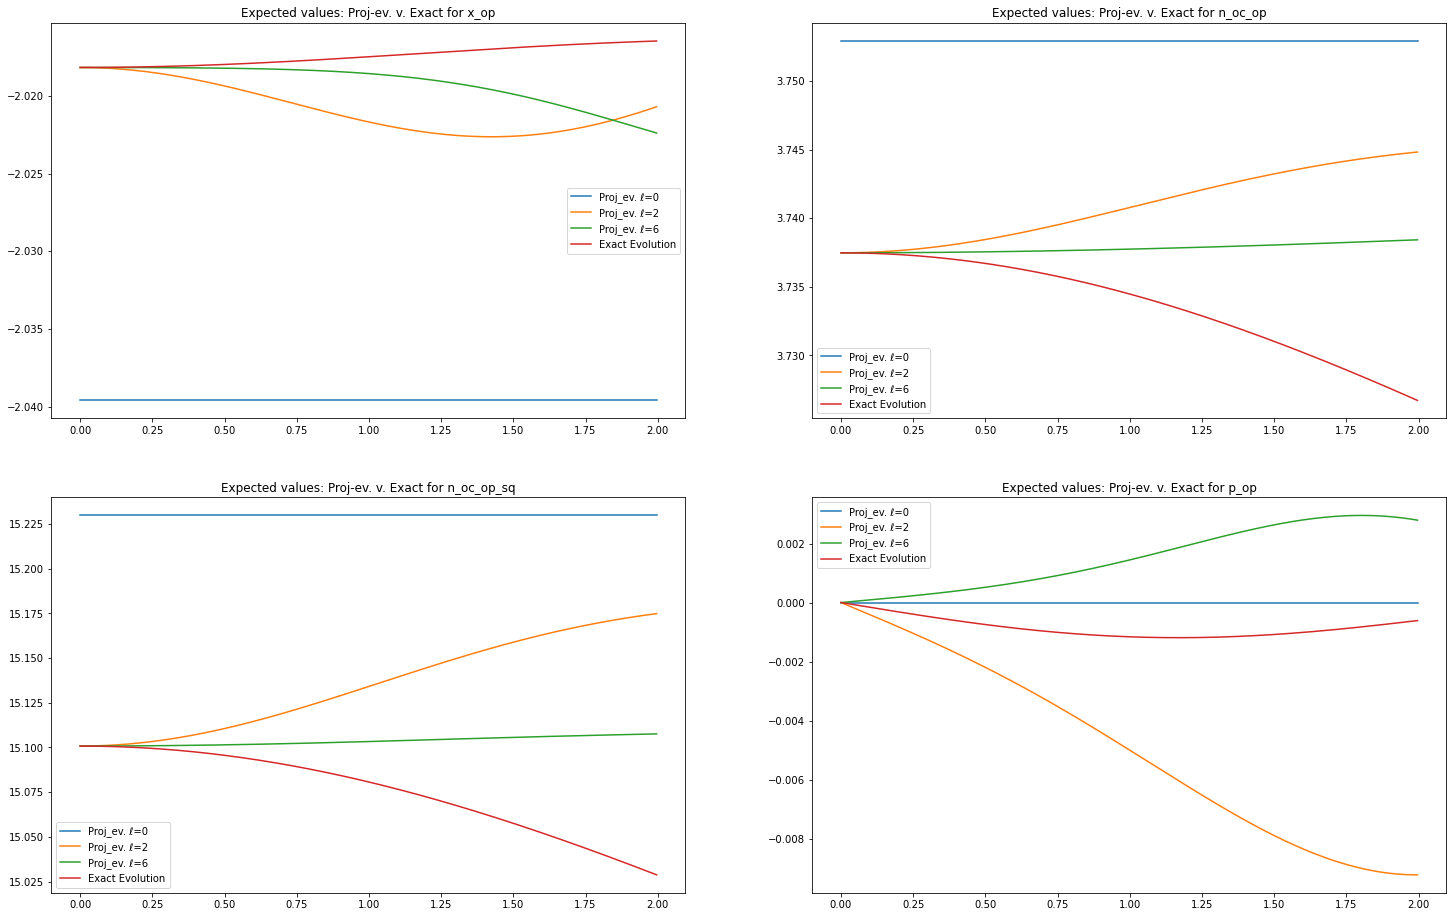

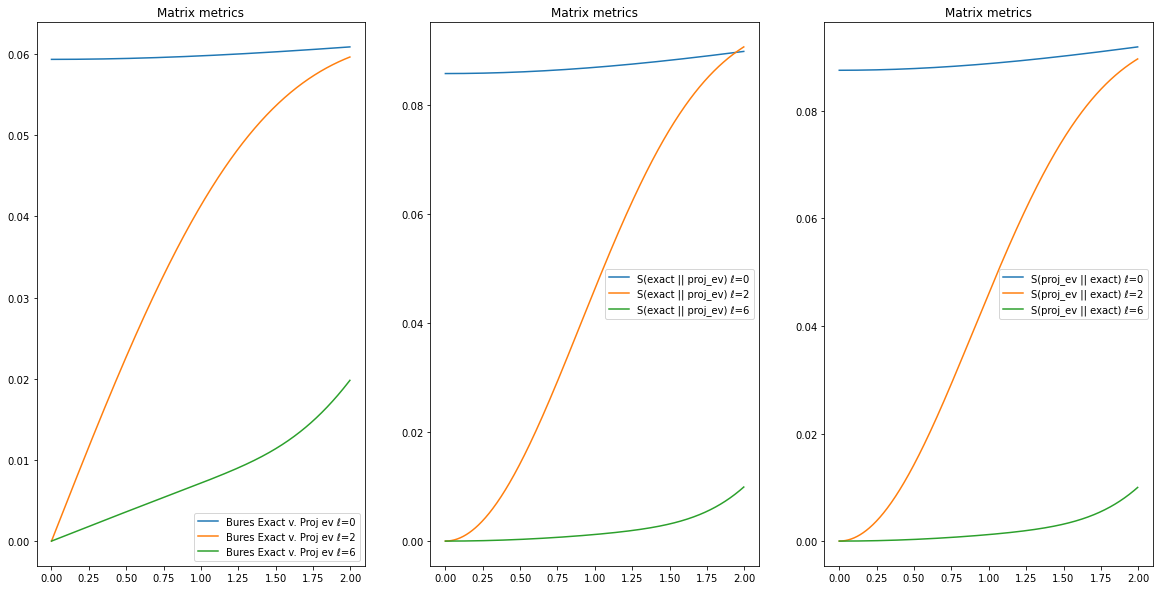

In [10]:
# N = 6, XY
ts = np.linspace(1e-5, 2.0, 500)
resultados = HBProjEv.HierarchBasis_vardim_proj_evs(Hamiltonian = H_H, fixed_ops_list = fixed_ops_list,
                                                    rho_ref = custom_rho_ref, 
                                              range_derived_series_orders = range_derived_series_orders, 
                                     temp_ref = temp_ref, temp_rho = temp,
                                     generating_operator = spin_ops_list[1][0],
                                     init_coeff_list = all_coeff_lists,
                                     timespan = ts, label_ops = subset_label_ops,
                                     observables = list(subset_of_observables.values()),
                                     rho_ref_equal_rho0 = False)

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                          plot_var_HierarchBases_dim = True)

metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = range_derived_series_orders,
                                                                  multiple_evolutions = resultados,
                                                plot_var_HierarchBases_dim = True)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = range_derived_series_orders,
                                                     metric_local = metrics,
                                          plot_var_HierarchBases_dim = True)

## FFT de los observables XX

In [21]:
avsg_xop_sq_exact = resultados["res_exact_all"]['res_exact_HierarchBases2'].expect[1][:-1]
avgs_xop_sq_HB0 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases0"]["Avgs"][1]
avgs_xop_sq_HB1 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases1"]["Avgs"][1]
avgs_xop_sq_HB2 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases2"]["Avgs"][1]

avsg_xop_sq_exact = resultados["res_exact_all"]['res_exact_HierarchBases2'].expect[1][:-1]
avgs_xop_sq_HB0 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases0"]["Avgs"][1]
avgs_xop_sq_HB1 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases1"]["Avgs"][1]
avgs_xop_sq_HB2 = resultados["dict_res_proj_ev_all"]["dict_res_proj_ev_HierarchBases2"]["Avgs"][1]

freq_fft = np.fft.fftfreq(ts.shape[-1])
freq_plot = [freq_fft[t] for t in range(len(freq_fft)) if (t <= -0.2 or t >= 0.2)]
freqs_fft_avgs_n_oc_op_sq_exact = np.fft.fft(avsg_xop_sq_exact)[1:]
freqs_fft_avgs_n_oc_op_sq = np.fft.fft(avgs_xop_sq_HB2)[1:]


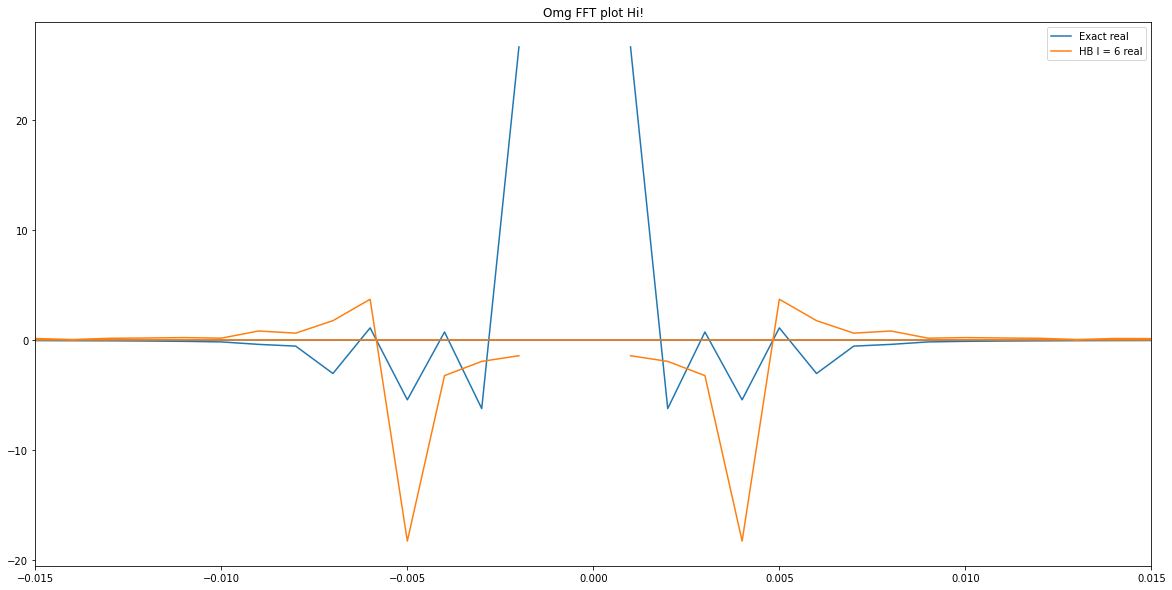

In [19]:
fig = plt.figure(figsize=(20, 10))
plt.plot(freq_plot[:-1], freqs_fft_avgs_n_oc_op_sq_exact.real + 1j * freqs_fft_avgs_n_oc_op_sq_exact.imag, label = "Exact real")
plt.plot(freq_plot[:-1], freqs_fft_avgs_n_oc_op_sq.real, label = "HB l = 6 real")
plt.plot(freq_plot[:-1], freqs_fft_avgs_n_oc_op_sq.real, label = "HB l = 6 real")
plt.xlim(-.015, .015)
plt.title("Omg FFT plot Hi!")
plt.legend()

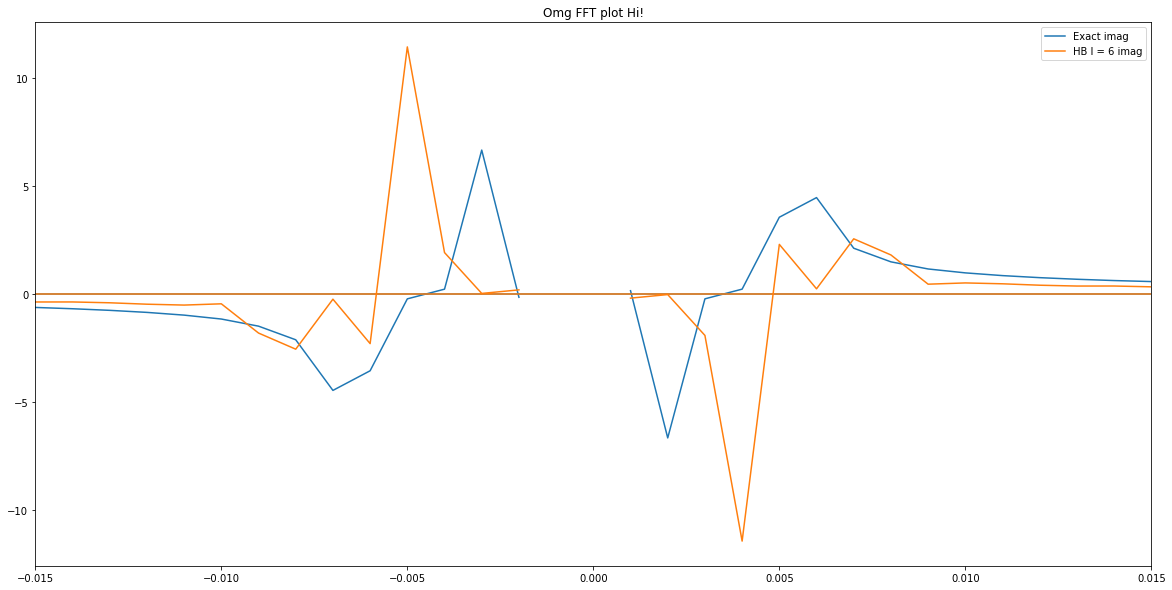

In [20]:
fig = plt.figure(figsize=(20, 10))
plt.plot(freq_plot[:-1], freqs_fft_avgs_n_oc_op_sq_exact.imag, label = "Exact imag")
plt.plot(freq_plot[:-1], freqs_fft_avgs_n_oc_op_sq.imag, label = "HB l = 6 imag")
plt.xlim(-.015, .015)
plt.title("Omg FFT plot Hi!")
plt.legend()

In [24]:
abs()

0.37417882995989726